In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torchvision.models as models
from torch.functional import F
from torchvision import datasets, transforms
import cv2

In [0]:
transform1 = transforms.Compose([transforms.Resize(256), transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
transform2 = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

sourcedata = datasets.ImageFolder('amazon/images', transform = transform1)
sourceloader = torch.utils.data.DataLoader(sourcedata, batch_size = 16, shuffle=True)

targetdata = datasets.ImageFolder('dslr/images/', transform=transform1)
targetloader = torch.utils.data.DataLoader(targetdata, batch_size=16, shuffle=True)

testdata = datasets.ImageFolder('dslr/images/', transform=transform2)
testloader = torch.utils.data.DataLoader(testdata, batch_size=16, shuffle=True)

In [5]:
print(sourceloader.dataset.classes)

['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
tensor(5)


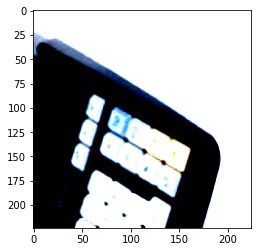

In [6]:
for batch_idx,(img, label) in enumerate(sourceloader):
    img = img.permute(0, 3, 2, 1)
    print(img[0].shape)
    plt.imshow(img[0])
    print(label[0])
    break

In [0]:
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)


def mmd_rbf_noaccelerate(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

In [0]:
class Model(nn.Module):
    def __init__(self, model_func = models.resnet50, pretrnd = True, training = True):
        super().__init__()
        self.resnet = model_func(pretrained = pretrnd)
        self.classifier = nn.Linear(self.resnet.fc.in_features, 31)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        
    def forward(self, source, target):
        loss = torch.cuda.FloatTensor([0])
        source = self.resnet(source)
        source = source.view(source.size(0), -1)
        if self.training:
            target = self.resnet(target)
            target = target.view(target.size(0), -1)
            loss = mmd_rbf_noaccelerate(source, target)
            target = self.classifier(target)
        source = self.classifier(source)
        return loss,source,target

    def nforward(self, source):
        source = self.resnet(source)
        source = source.view(source.size(0), -1)
        source = self.classifier(source)
        return source

In [0]:
def evalu(model, target_dataloader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in target_dataloader:
            data, target = data.to(device), target.to(device)
            output = model.nforward(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(target_dataloader.dataset)
    del output
    return acc

In [0]:
def training_da_one_epoch(source_dataloader, target_dataloader, teacher, optimizer, device):
    t_loss = 0.
    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)
    for i in range(1, len(sourceloader) + 1):
        source_data, source_label = source_iter.next()
        target_data, target_label = target_iter.next()

        if source_data.shape[0] != target_data.shape[0]:
            if target_data.shape[0] < source_dataloader.batch_size:
                target_iter = iter(target_dataloader)
                target_data, target_label = target_iter.next()

            if source_data.shape[0] < source_dataloader.batch_size:
                target_data = target_data[:source_data.shape[0]]

        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)

        optimizer.zero_grad()
        mmd_loss, source_o, target_o = teacher(source_data, target_data)
        cls_loss = F.nll_loss(F.log_softmax(source_o, dim=1), source_label)
        lambd = 2 / (1 + np.exp(-10 * (i) / len(source_dataloader))) - 1
        loss = cls_loss + lambd * mmd_loss
        t_loss += loss.mean().item()
        loss.mean().backward()
        optimizer.step()
    return t_loss / len(source_dataloader)

In [0]:
def training_da(epochs, source_dataloader, target_dataloader, teacher, optimizer, device, schedular = None ):
    teacher.train()
    best_acc = 0
    for epoch in range(epochs):
        loss = training_da_one_epoch(source_dataloader, target_dataloader, teacher, optimizer, device)
        acc = evalu(teacher, target_dataloader, device)
        #schedular.step()
        if acc>best_acc:
            best_acc = acc
        print(f"Epoch : {epoch}/{epochs}")
        print(f"DA_Loss : {loss}")
        print(f"Accuracy : {acc}")
    return teacher, best_acc, optimizer

In [0]:
def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 0.5 every 20 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [0]:
def kd_loss_wo_ce_func(y_teacher, y_student, T, dist_loss=F.kl_div):
    p = F.log_softmax(y_teacher/T, dim=1)
    q = F.softmax(y_student/T, dim=1)
    if dist_loss == F.kl_div:
        l_kl = dist_loss(p, q, size_average=False) * (T**2) / y_teacher.shape[0]
    elif dist_loss == F.mse_loss:
        l_kl = dist_loss(p, q, size_average=False) / y_teacher.shape[0]
    return l_kl

In [0]:
def kd_loss_func(y_teacher, y_student, labels, T, alpha, dist_loss=F.kl_div):
    p = F.log_softmax(y_teacher/T, dim=1)
    q = F.softmax(y_student/T, dim=1)
    if dist_loss == F.kl_div:
        l_kl = dist_loss(p, q, size_average=False) * (T**2) / y_teacher.shape[0]
    elif dist_loss == F.mse_loss:
        l_kl = dist_loss(p, q, size_average=False) / y_teacher.shape[0]
    l_ce = F.cross_entropy(y_teacher, labels)
    return l_kl * alpha + l_ce * (1. - alpha)

In [0]:
def da_kd_joint_one_epoch(student, teacher, source_dataloader, target_dataloader, optimizer_da, optimizer_kd, T, alpha, beta, device):

    student.train()
    teacher.train()
    kd_loss_t = 0
    kd_loss_s = 0
    kd_loss = 0
    da_loss = 0
    total_loss = 0
    
    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)
    
    for i in range(0, len(source_dataloader)):
        source_data, source_label = source_iter.next()
        target_data, target_label = target_iter.next()
        
        if source_data.shape[0] != target_data.shape[0]:
            if target_data.shape[0] < source_dataloader.batch_size:
                target_iter = iter(target_dataloader)
                target_data, target_label = target_iter.next()

            if source_data.shape[0] < source_dataloader.batch_size:
                target_data = target_data[:source_data.shape[0]]
                
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        target_label = target_label.to(device)
        
        optimizer_da.zero_grad()
        optimizer_kd.zero_grad()
        
        teacher_mmd_loss, source_o, target_o = teacher(source_data, target_data)
        cls_loss = F.nll_loss(F.log_softmax(source_o, dim=1), source_label)
        lambd = 2 / (1 + np.exp(-10 * (i) / len(source_dataloader))) - 1
        da_loss_temp = (1 - beta ) * (cls_loss + lambd * teacher_mmd_loss)
        da_loss += da_loss_temp.mean().item()
        da_loss_temp.mean().backward()
        optimizer_da.step()
        
        teacher_mmd_loss, teacher_source_o, teacher_target_o = teacher(source_data, target_data)
        student_mmd_loss, student_source_o, student_target_o = student(source_data, target_data)
        
        teacher_kd_loss = kd_loss_wo_ce_func(teacher_target_o, student_target_o, T).abs()
        student_kd_loss = kd_loss_func(teacher_target_o, student_target_o, source_label, T, alpha).abs()
        
        kd_loss_t += teacher_kd_loss.mean().item()
        kd_loss_s += student_kd_loss.mean().item()
        
        kd_loss_temp = beta * (teacher_kd_loss + student_kd_loss)
        kd_loss += kd_loss_temp.mean().item()
        total_loss += kd_loss_temp.mean().item() + da_loss_temp.mean().item()
        kd_loss_temp.mean().backward()
        optimizer_kd.step()
        
    return total_loss / len(source_dataloader), da_loss / len(source_dataloader), kd_loss / len(source_dataloader), kd_loss_s / len(source_dataloader), kd_loss_t / len(source_dataloader)

In [0]:
def kd_da_joint(epochs, student, teacher, source_dataloader, target_dataloader, test_loader, optimizer_da, optimizer_kd, T, alpha, growth_rate, init_lr_da, init_lr_kd, init_beta, device, is_scheduler_da=True, is_scheduler_kd=False, scheduler_da=None, scheduler_kd=None):
    beta = init_beta
    lr_kd = init_lr_da
    lr_da = init_lr_kd
    
    best_teacher_acc = 0
    best_student_acc = 0
    student.to(device)
    teacher.to(device)

    for epoch in range(1,epochs+1):

        beta = init_beta * torch.exp((epoch -1) * growth_rate)
        beta = beta.to(device)

        if is_scheduler_da:
            new_lr_da = init_lr_da / np.power((1 + 10 * (epoch - 1) / epochs), 0.75) # 10*
            adjust_learning_rate(optimizer_da, new_lr_da)

        if is_scheduler_kd:
            new_lr_kd = init_lr_kd / np.power((1 + 10 * (epoch - 1) / epochs), 0.75) # 10*
            adjust_learning_rate(optimizer_kd, new_lr_kd)

        total_loss, da_loss, kd_loss, kd_loss_s, kd_loss_t =  da_kd_joint_one_epoch(student, teacher, source_dataloader, target_dataloader, optimizer_da, optimizer_kd, T, alpha, beta, device)
        
        teacher_acc = evalu(teacher, test_loader, device)
        student_acc = evalu(student, test_loader, device)
        
        if teacher_acc > best_teacher_acc:
            best_teacher_acc = teacher_acc
        if student_acc > best_student_acc:
            best_student_acc = student_acc
            torch.save({
            'epoch': epoch,
            'model_state_dict': student.state_dict(),
            'optimizer_state_dict_kd': optimizer_kd.state_dict(),
            'optimizer_state_dict_da': optimizer_da.state_dict(),
            'total_loss': total_loss,
            'student_loss': kd_loss_s,
            }, './kd_uda.pth')
                
        print(f'Epochs : {epoch}')
        print(f'Total Loss :  {total_loss}\tDA_loss : {da_loss}\tKD_loss : {kd_loss}\tKD_loss_s : {kd_loss_s}\tKD_loss_t : {kd_loss_t}')
        print(f'Accuracy student :  {student_acc}\tAccuracy teacher : {teacher_acc}')

        if ((scheduler_da is not None) and (epoch % 10 == 0)) :
            scheduler_da.step()

        if scheduler_kd is not None:
            scheduler_kd.step()

    return best_student_acc

In [0]:
init_beta = 0.1
end_beta = 0.9
T = 20
alpha = .8
epochs = 5   #Run for 400 epochs
growth_rate = torch.log(torch.FloatTensor([end_beta / init_beta])) / torch.FloatTensor([epochs])
init_lr_da = .001
init_lr_kd = .0001
momentum = 0.9
weight_decay = 5e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
student = Model(models.resnet34)
teacher = Model(models.resnet50)
optimizer_da = torch.optim.SGD(list(teacher.parameters()) + list(student.parameters()), init_lr_da, momentum=momentum, weight_decay=weight_decay)
optimizer_kd = torch.optim.SGD(list(teacher.parameters()) + list(student.parameters()), init_lr_kd, momentum=momentum, weight_decay=weight_decay)

In [ ]:
acc = kd_da_joint(epochs, stu

In [23]:
dent, teacher, sourceloader, targetloader, testloader, optimizer_da, optimizer_kd, T, alpha, growth_rate, init_lr_da, init_lr_kd, init_beta, device, is_scheduler_da=True, is_scheduler_kd=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epochs : 1
Total Loss :  2.408153658027703	DA_loss : 2.242667545706539	KD_loss : 0.16548611232116398	KD_loss_s : 1.155374049466882	KD_loss_t : 0.49948705126673487
Accuracy student :  1.8072289156626506	Accuracy teacher : 63.65461847389558
Epochs : 2
Total Loss :  1.5382379118332081	DA_loss : 1.173559561287616	KD_loss : 0.3646783505455922	KD_loss_s : 1.5454660404873433	KD_loss_t : 0.8044995150955047
Accuracy student :  4.819277108433735	Accuracy teacher : 71.285140562249
Epochs : 3
Total Loss :  1.4610478151484398	DA_loss : 0.9258992160107457	KD_loss : 0.5351485991376942	KD_loss_s : 1.4976186779259288	KD_loss_t : 0.7245517822224542
Accuracy student :  6.827309236947791	Accuracy teacher : 72.89156626506023
Epochs : 4
Total Loss :  1.452847282428526	DA_loss : 0.7175208333521913	KD_loss : 0.7353264490763346	KD_loss_s : 1.3700005371691817	KD_loss_t : 0.5975896754870349
Accuracy student :  9.036144578313253	Accuracy teacher : 75.50200803212851
Epochs : 5
Total Loss :  1.4086957469498371	DA_l